In [1]:

import os
from dotenv import load_dotenv

load_dotenv()
APIKEY = os.getenv("APIKEY")
APIKEY_ANTHROPIC = os.getenv("APIKEY_ANTHROPIC")
APIKEY_VOYAGER = os.getenv("APIKEY_VOYAGER")

In [2]:
import openai

# Replace 'your-api-key' with your actual OpenAI API key
openai.api_key = APIKEY

# openai.api_key = api_key

# Define the prompt
prompt = "If you had to choose, on a scale from 1 to 10, how cute are cats? Output a single integer."

# Request with logprobs
response = openai.Completion.create(
    model="text-davinci-003",  # Use a completion model
    prompt=prompt,
    max_tokens=1,              # Expecting a single integer
    temperature=0,             # Deterministic response
    logprobs=10                # Get log probabilities of top tokens
)

# Extract logprobs
logprobs = response.choices[0].logprobs.top_logprobs[0]

# Convert logprobs to probabilities
probabilities = {token: math.exp(logprob) for token, logprob in logprobs.items()}

# Filter and normalize probabilities for numbers 1-10
number_probabilities = {int(token.strip()): prob for token, prob in probabilities.items() if token.strip().isdigit() and 1 <= int(token.strip()) <= 10}
total_prob = sum(number_probabilities.values())
normalized_probabilities = {num: prob / total_prob for num, prob in number_probabilities.items()}

# Print normalized probabilities
print("Normalized Probabilities for Numbers 1-10:")
for number, probability in sorted(normalized_probabilities.items()):
    print(f"Number: {number}, Probability: {probability:.4f}")



APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742


In [25]:
from openai import AsyncOpenAI


aclient = AsyncOpenAI(
    api_key = APIKEY
)
async def get_log_probs(contents: str):
    response = await aclient.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": contents}],
        stream=True,
        logprobs=True,
    )
    token_log_probs = {}
    async for chunk in response:
        choice = chunk.choices[0]
        content = choice.delta.content
        log_probs = choice.logprobs
        print(log_probs)
        if content and log_probs:
            log_prob = log_probs.content[0].logprob
            token_log_probs[content] = log_prob
    return token_log_probs
log_probs = await get_log_probs("If you had to choose, on a scale from 1 to 10, how cute are cats? Output a single integer.")
log_probs

ChoiceLogprobs(content=[], refusal=None)
ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='9', bytes=[57], logprob=-0.25786915, top_logprobs=[])], refusal=None)
None


{'9': -0.25786915}

In [2]:
from openai import OpenAI
from math import exp
import numpy as np
from IPython.display import display, HTML
import os

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", APIKEY))

In [3]:
def get_completion(
    messages: list[dict[str, str]],
    model: str = "gpt-4",
    max_tokens=500,
    temperature=0,
    stop=None,
    seed=123,
    tools=None,
    logprobs=None,  # whether to return log probabilities of the output tokens or not. If true, returns the log probabilities of each output token returned in the content of message..
    top_logprobs=None,
) -> str:
    params = {
        "model": model,
        "messages": messages,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "stop": stop,
        "seed": seed,
        "logprobs": logprobs,
        "top_logprobs": top_logprobs,
    }
    if tools:
        params["tools"] = tools

    completion = client.chat.completions.create(**params)
    return completion

In [4]:
CLASSIFICATION_PROMPT = """You will be given a headline of a news article.
Classify the article into one of the following categories: Technology, Politics, Sports, and Art.
Return only the name of the category, and nothing else.
MAKE SURE your output is one of the four categories stated.
Article headline: {headline}"""
headlines = [
    "Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.",
    "Local Mayor Launches Initiative to Enhance Urban Public Transport.",
    "Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut",
]

In [8]:
for headline in headlines:
    print(f"\nHeadline: {headline}")
    API_RESPONSE = get_completion(
        [{"role": "user", "content": CLASSIFICATION_PROMPT.format(headline=headline)}],
        model="gpt-4",
    )
    print(f"Category: {API_RESPONSE.choices[0].message.content}\n")


Headline: Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.
Category: Technology


Headline: Local Mayor Launches Initiative to Enhance Urban Public Transport.
Category: Politics


Headline: Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut
Category: Art



In [10]:
CLASSIFICATION_PROMPT.format(headline=headline)

'You will be given a headline of a news article.\nClassify the article into one of the following categories: Technology, Politics, Sports, and Art.\nReturn only the name of the category, and nothing else.\nMAKE SURE your output is one of the four categories stated.\nArticle headline: Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut'

# Classification of headlines

In [9]:


for headline in headlines:
    print(f"\nHeadline: {headline}")
    API_RESPONSE = get_completion(
        [{"role": "user", "content": CLASSIFICATION_PROMPT.format(headline=headline)}],
        model="gpt-4o",
        logprobs=True,
        top_logprobs=2,
    )
    top_two_logprobs = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs
    html_content = ""
    for i, logprob in enumerate(top_two_logprobs, start=1):
        html_content += (
            f"<span style='color: cyan'>Output token {i}:</span> {logprob.token}, "
            f"<span style='color: darkorange'>logprobs:</span> {logprob.logprob}, "
            f"<span style='color: magenta'>linear probability:</span> {np.round(np.exp(logprob.logprob)*100,2)}%<br>"
        )
    display(HTML(html_content))
    print("\n")


Headline: Tech Giant Unveils Latest Smartphone Model with Advanced Photo-Editing Features.





Headline: Local Mayor Launches Initiative to Enhance Urban Public Transport.





Headline: Tennis Champion Showcases Hidden Talents in Symphony Orchestra Debut


In [13]:
# Article retrieved
ada_lovelace_article = """Augusta Ada King, Countess of Lovelace (née Byron; 10 December 1815 – 27 November 1852) was an English mathematician and writer, chiefly known for her work on Charles Babbage's proposed mechanical general-purpose computer, the Analytical Engine. She was the first to recognise that the machine had applications beyond pure calculation.
Ada Byron was the only legitimate child of poet Lord Byron and reformer Lady Byron. All Lovelace's half-siblings, Lord Byron's other children, were born out of wedlock to other women. Byron separated from his wife a month after Ada was born and left England forever. He died in Greece when Ada was eight. Her mother was anxious about her upbringing and promoted Ada's interest in mathematics and logic in an effort to prevent her from developing her father's perceived insanity. Despite this, Ada remained interested in him, naming her two sons Byron and Gordon. Upon her death, she was buried next to him at her request. Although often ill in her childhood, Ada pursued her studies assiduously. She married William King in 1835. King was made Earl of Lovelace in 1838, Ada thereby becoming Countess of Lovelace.
Her educational and social exploits brought her into contact with scientists such as Andrew Crosse, Charles Babbage, Sir David Brewster, Charles Wheatstone, Michael Faraday, and the author Charles Dickens, contacts which she used to further her education. Ada described her approach as "poetical science" and herself as an "Analyst (& Metaphysician)".
When she was eighteen, her mathematical talents led her to a long working relationship and friendship with fellow British mathematician Charles Babbage, who is known as "the father of computers". She was in particular interested in Babbage's work on the Analytical Engine. Lovelace first met him in June 1833, through their mutual friend, and her private tutor, Mary Somerville.
Between 1842 and 1843, Ada translated an article by the military engineer Luigi Menabrea (later Prime Minister of Italy) about the Analytical Engine, supplementing it with an elaborate set of seven notes, simply called "Notes".
Lovelace's notes are important in the early history of computers, especially since the seventh one contained what many consider to be the first computer program—that is, an algorithm designed to be carried out by a machine. Other historians reject this perspective and point out that Babbage's personal notes from the years 1836/1837 contain the first programs for the engine. She also developed a vision of the capability of computers to go beyond mere calculating or number-crunching, while many others, including Babbage himself, focused only on those capabilities. Her mindset of "poetical science" led her to ask questions about the Analytical Engine (as shown in her notes) examining how individuals and society relate to technology as a collaborative tool.
"""

# Questions that can be easily answered given the article
easy_questions = [
    "What nationality was Ada Lovelace?",
    "What was an important finding from Lovelace's seventh note?",
]

# Questions that are not fully covered in the article
medium_questions = [
    "Did Lovelace collaborate with Charles Dickens",
    "What concepts did Lovelace build with Charles Babbage",
]

In [14]:
PROMPT = """You retrieved this article: {article}. The question is: {question}.
Before even answering the question, consider whether you have sufficient information in the article to answer the question fully.
Your output should JUST be the boolean true or false, of if you have sufficient information in the article to answer the question.
Respond with just one word, the boolean true or false. You must output the word 'True', or the word 'False', nothing else.
"""

In [15]:
PROMPT

"You retrieved this article: {article}. The question is: {question}.\nBefore even answering the question, consider whether you have sufficient information in the article to answer the question fully.\nYour output should JUST be the boolean true or false, of if you have sufficient information in the article to answer the question.\nRespond with just one word, the boolean true or false. You must output the word 'True', or the word 'False', nothing else.\n"

In [17]:
html_output = ""
html_output += "Questions clearly answered in article"

for question in easy_questions:
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        model="gpt-4",
        logprobs=True,
    )
    html_output += f'<p style="color:green">Question: {question}</p>'
    for logprob in API_RESPONSE.choices[0].logprobs.content:
        html_output += f'<p style="color:cyan">has_sufficient_context_for_answer: {logprob.token}, <span style="color:darkorange">logprobs: {logprob.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(logprob.logprob)*100,2)}%</span></p>'

html_output += "Questions only partially covered in the article"

for question in medium_questions:
    API_RESPONSE = get_completion(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    article=ada_lovelace_article, question=question
                ),
            }
        ],
        model="gpt-4",
        logprobs=True,
        top_logprobs=2,
    )
    html_output += f'<p style="color:green">Question: {question}</p>'
    for logprob in API_RESPONSE.choices[0].logprobs.content:
        html_output += f'<p style="color:cyan">has_sufficient_context_for_answer: {logprob.token}, <span style="color:darkorange">logprobs: {logprob.logprob}, <span style="color:magenta">linear probability: {np.round(np.exp(logprob.logprob)*100,2)}%</span></p>'

display(HTML(html_output))

# LOG PROB CODE

In [179]:
import pandas as pd
from typing import List, Optional
import math

def process_top_logprobs(
    top_logprobs: List,
    convert_type: Optional[str] = None
) -> pd.DataFrame:
    """
    Processes a list of TopLogprob objects into a pandas DataFrame with additional metrics.
    
    Parameters
    ----------
    top_logprobs : List
        A list of TopLogprob objects, each containing 'token', 'bytes', and 'logprob' attributes.
    
    convert_type : Optional[str], default=None
        Specifies the desired data type for the 'token' column.
        - 'int' : Convert tokens to integers.
        - 'float' : Convert tokens to floats.
        - 'bool' : Convert tokens to booleans.
        - None : No conversion applied.
        
        Tokens that cannot be converted to the specified type will be excluded from the DataFrame.
    
    Returns
    -------
    pd.DataFrame
        A pandas DataFrame with columns:
        - 'token' : The token, optionally converted to the specified type.
        - 'bytes' : The byte representation of the token.
        - 'logprob' : The log probability of the token.
        - 'prob' : The probability of the token, calculated as exp(logprob).
        - 'perplexity' : The perplexity, calculated as exp(-logprob).
    
    Raises
    ------
    ValueError
        If `convert_type` is not one of 'int', 'float', 'bool', or None.
        If `top_logprobs` is not a list.
        If any TopLogprob object does not have the required attributes.
    """
    
    # Input validation
    if not isinstance(top_logprobs, list):
        raise ValueError("`top_logprobs` must be a list of TopLogprob objects.")
    
    valid_types = {'int', 'float', 'bool', None}
    if convert_type not in valid_types:
        raise ValueError("`convert_type` must be one of 'int', 'float', 'bool', or None.")
    
    # Extract data
    data = []
    for idx, item in enumerate(top_logprobs):
        try:
            token = item.token
            bytes_list = item.bytes
            logprob = item.logprob
            prob = math.exp(logprob)
            perplexity = math.exp(-logprob)
            data.append({
                'token': token,
                'bytes': bytes_list,
                'logprob': logprob,
                'prob': prob,
                'perplexity': perplexity
            })
        except AttributeError as e:
            raise ValueError(f"TopLogprob object at index {idx} is missing required attributes.") from e
        except (TypeError, ValueError) as e:
            raise ValueError(f"Invalid data in TopLogprob object at index {idx}: {e}") from e
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Optional type conversion
    if convert_type:
        type_mapping = {
            'int': 'Int64',   # Use pandas nullable integer dtype
            'float': 'float64',
            'bool': 'bool'
        }
        dtype = type_mapping.get(convert_type)
        
        if convert_type == 'bool':
            # Define truthy values
            truthy_values = {'true', '1', 't', 'yes'}
            df['token_converted'] = df['token'].astype(str).str.lower().isin(truthy_values)
        else:
            df['token_converted'] = pd.to_numeric(df['token'], errors='coerce')
        
        # Drop rows where conversion failed (NaN values or False for bool)
        if convert_type == 'bool':
            df = df[df['token_converted'] == True]
        else:
            df = df.dropna(subset=['token_converted'])
            df['token_converted'] = df['token_converted'].astype(dtype)
        
        # Assign the converted column back to 'token' and drop the helper column
        df['token'] = df['token_converted']
        df = df.drop(columns=['token_converted'])
    
    return df

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_logprob_dataframe(
    df: pd.DataFrame,
    y_column: str = 'perplexity',
    palette: Optional[str] = 'viridis',
    use_beta_model: bool =True,
    figsize: tuple = (12, 8)
) -> None:
    """
    Plots a bar chart of the specified metric for each token with a density curve overlay.
    
    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing at least 'token' and the specified y_column.
    
    y_column : str, default='perplexity'
        The column to plot on the y-axis. Must be one of 'perplexity', 'logprob', or 'prob'.
    
    palette : Optional[str], default='viridis'
        The seaborn color palette to use for the bars.
    
    figsize : tuple, default=(12, 8)
        The size of the plot in inches, as (width, height).
    
    Returns
    -------
    None
        Displays the plot.
    
    Raises
    ------
    ValueError
        If `y_column` is not one of 'perplexity', 'logprob', or 'prob'.
        If required columns are missing from the DataFrame.
    """
    
    # Validate y_column
    valid_columns = {'perplexity', 'logprob', 'prob'}
    if y_column not in valid_columns:
        raise ValueError(f"`y_column` must be one of {valid_columns}.")
    
    # Check required columns in DataFrame
    required_columns = {'token', y_column}
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"The DataFrame is missing required columns: {missing_columns}")
    
    # Sort the DataFrame by token (assuming tokens are numeric and sortable)
    df_sorted = df.sort_values(by='token')
    
    # Initialize the matplotlib figure
    plt.figure(figsize=figsize)
    
    # Set seaborn context for blog-friendly aesthetics
    sns.set_context("talk")
    sns.set_style("whitegrid")
    
    # Create the barplot using token as numeric x-axis
    plt.bar(
        x=df_sorted['token'],
        height=df_sorted[y_column],
        color=sns.color_palette(palette, len(df_sorted)),
        alpha=0.8,
        label="Bar Plot"
    )
    
    
    # Overlay density curve
    if use_beta_model:
        from scipy.stats import beta
        
        # Normalize the token values to (0, 1) for beta fitting
        epsilon = 1e-6  # A small value to shift the boundaries
        normalized_tokens = (df_sorted['token'] - 1) / (10 - 1)
        normalized_tokens = np.clip(normalized_tokens, epsilon, 1 - epsilon)
        
        # Fit a beta distribution to the normalized data
        a, b, loc, scale = beta.fit(normalized_tokens, floc=0, fscale=1)
        
        # Generate a smooth curve based on the beta distribution
        x = np.linspace(1, 10, 20)
        normalized_x = (x - 1) / (10 - 1)
        density = beta.pdf(normalized_x, a, b, loc=loc, scale=scale)

        # Ensure no infinite values in density
        density = np.where(np.isfinite(density), density, 0)
        
        # Scale density to align with weights (df_sorted[y_column])
        density *= np.sum(df_sorted[y_column]) / np.sum(density)

        
        # Plot the beta-modeled density
        plt.plot(x, density, color='blue', linewidth=2, label='Beta Model')
    else:
        pass
        # Default KDE plot with actual values
        # sns.kdeplot(
        #     x=df_sorted['token'],
        #     weights=df_sorted[y_column],
        #     color='red',
        #     linewidth=2,
        #     fill=False,
        #     label='Density'
        # )

    
    # Customize the plot
    plt.title(f'Bar Plot of {y_column.capitalize()} by Token', fontsize=16)
    plt.xlabel('Token', fontsize=14)
    plt.ylabel(y_column.capitalize(), fontsize=14)
    
    # Set x-axis range and ticks
    plt.xlim(0, 11)  # Ensure the x-axis always covers the range 0-11
    plt.xticks(ticks=range(1, 11), labels=range(1, 11))  # Set ticks at integers 1 through 10
    
    # Rotate x-axis labels if tokens are numerous or overlapping
    if len(df_sorted) > 10:
        plt.xticks(rotation=45, ha='right')
    # Hide the top and right spines
    sns.despine(top=True, right=True)
    
    # Add legend for density curve
    plt.legend()
    
    # Adjust layout for better fit
    plt.tight_layout()
    
    # Show the plot
    plt.show()



In [190]:
PROMPT = "Weather in London is predicted to be horribly hot this summer, even worse than last year, in 2023. Based on the information given, what is a likely temperature in celcius that is projected in the text? respond with a number as a rough guess"
PROMPT = "On a scale from 1 to 10 where 10 is the highest score. How much do you like lions?? Return a single number"

API_RESPONSE = get_completion(
    [
        {
            "role": "user",
            "content": PROMPT,
        }
    ],
    model="gpt-4o",
    logprobs=True,
    top_logprobs=15,
)


# Assuming you have the API_RESPONSE object as described
top_logprobs_list = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs

# Process without type conversion
df_int = process_top_logprobs(top_logprobs_list) #, convert_type='int')
print(df_int)

     token                        bytes    logprob      prob     perplexity
0       As                    [65, 115]  -0.241009  0.785834       1.272533
1        8                         [56]  -1.991009  0.136558       7.322922
2        7                         [55]  -2.741009  0.064505      15.502622
3      I'm                [73, 39, 109]  -5.241009  0.005295     188.860567
4        I                         [73]  -5.366009  0.004673     214.007059
5        9                         [57]  -6.616009  0.001339     746.958031
6       10                     [49, 48]  -6.741009  0.001181     846.414337
7        6                         [54]  -7.991009  0.000338    2954.276321
8      I'd                [73, 39, 100]  -8.616010  0.000181    5519.320313
9     I'll           [73, 39, 108, 108] -10.991010  0.000017   59338.285464
10      My                    [77, 121] -11.116010  0.000015   67239.086381
11    It's           [73, 116, 39, 115] -11.116010  0.000015   67239.086381
12  That's  

    token bytes    logprob          prob    perplexity
0       3  [51]  -0.271906  7.619258e-01  1.312464e+00
1       2  [50]  -2.021906  1.324029e-01  7.552707e+00
2       4  [52]  -2.271906  1.031154e-01  9.697868e+00
3       5  [53]  -6.271906  1.888625e-03  5.294856e+02
4       1  [49]  -7.521906  5.411002e-04  1.848086e+03
6       6  [54] -10.271906  3.459138e-05  2.890894e+04
13      7  [55] -14.896906  3.391220e-07  2.948792e+06


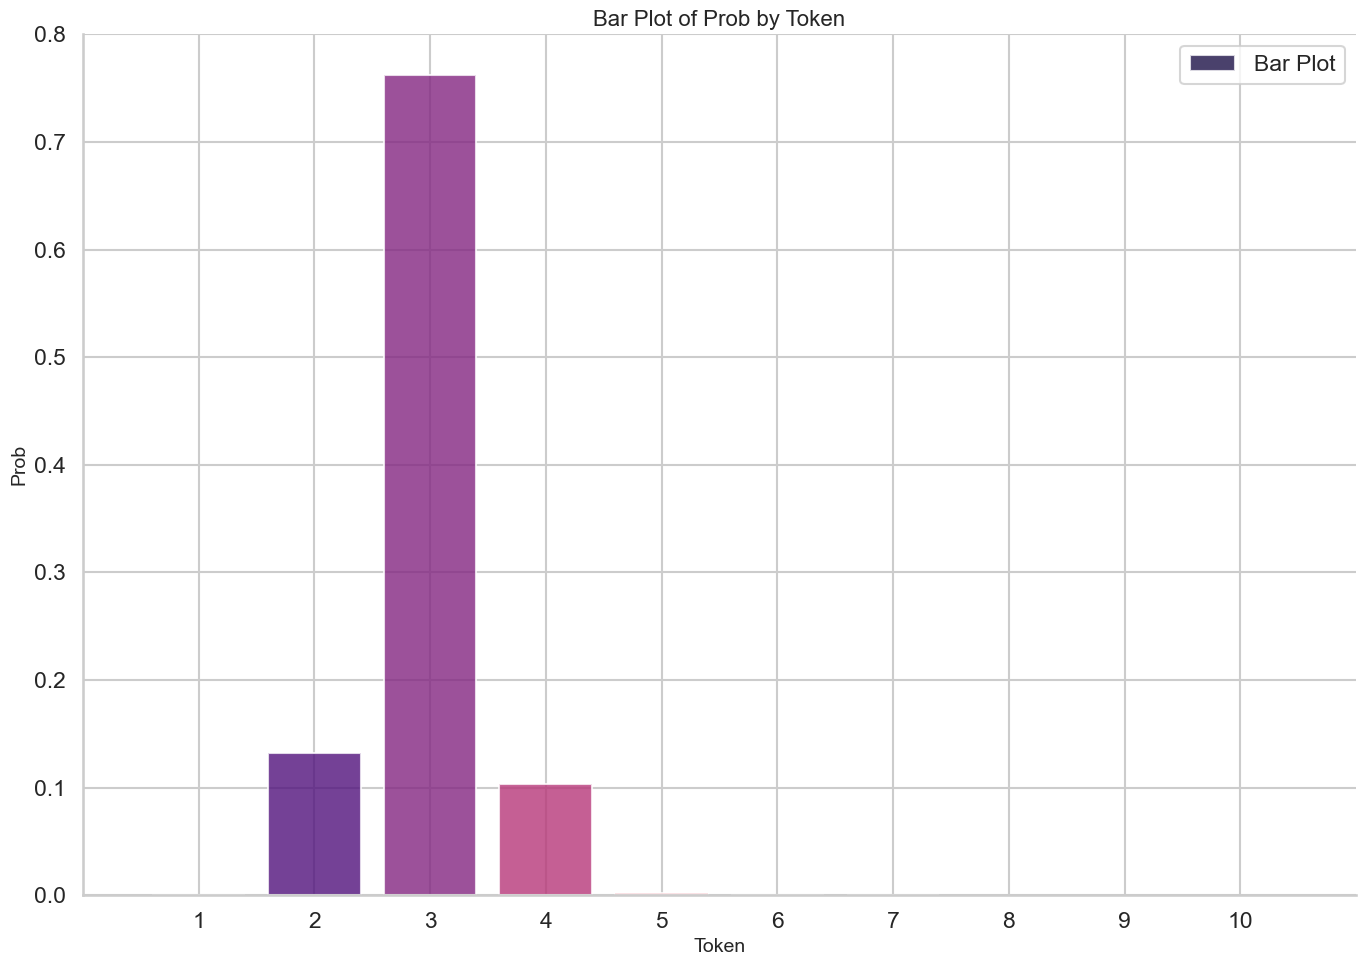

In [274]:
PROMPT= "If you had to pick your favourite number between 1 and 10 what would it be? Output a single integer"
PROMPT="On a scale from 1 to 10 where 10 is most likely. how likely is it that the humans destroy the earth by the year 2050. Just output a single integer"
# PROMPT="On a scale from 1 to 10 where 10 is most likely. how likely is it that ukraine join the EU soon. Just output a single integer"
# PROMPT="On a scale from 1 to 10 where 10 is most impactful. What is the negative biodiversity impact of Spotify. Just output a single integer"
# PROMPT = "Weather in London is predicted to be horribly cold this winter, even worse than last year, in 2023. On a scale of 1 (not) to 10 (very much), how much is this person looking forward to winter? Reply with a sinlge integer"
# PROMPT = "On a scale from 1 to 10 where 10 is the highest score. How much do you fear spiders? Think very carefully and Return a single number"

API_RESPONSE = get_completion(
    [
        {
            "role": "user",
            "content": PROMPT,
        }
    ],
    model="gpt-4o",
    logprobs=True,
    top_logprobs=15,
)


# Assuming you have the API_RESPONSE object as described
top_logprobs_list = API_RESPONSE.choices[0].logprobs.content[0].top_logprobs

# Process without type conversion
df_int = process_top_logprobs(top_logprobs_list, convert_type='int')
print(df_int)

plot_logprob_dataframe(df_int, y_column='prob', palette='magma', figsize=(14, 10), use_beta_model=False)


## embeddings

# test different types of embeddings:

# FULL CODE

# fullly worked out function:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Computing MDS for each block: 100%|██████████| 270/270 [00:01<00:00, 138.58it/s]


IndexError: range object index out of range

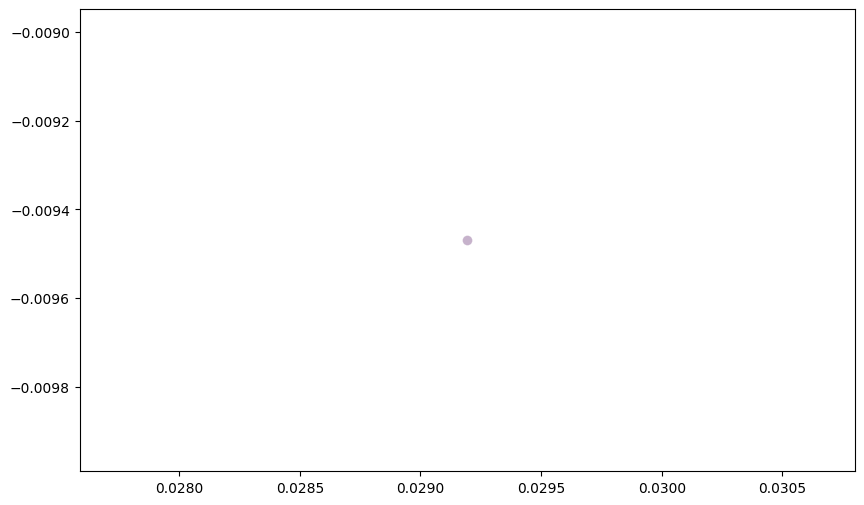

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from LLM_representational_space import MDSProjector

# Initialize the projector with OpenAI API key
mds_proj = MDSProjector(api_key=APIKEY)

CONCEPTS = [
    "judging beauty",
    "rating spiciness",
    "evaluating humor",
    "judging difficulty",
    "rating brightness",
    "assessing intelligence", ###
    "scoring flavor",
    "measuring volume",
    "appraising strength",
    "estimating reliability",
    "judging a professional cooking competition",
    "scoring the biodiversity score of a company",
    "evaluating artistic creativity",  ####
    "judging the emotional impact of a song",
    "rating the realism of a movie plot",
    "assessing the comfort of a chair",
    "scoring the user-friendliness of a mobile app",
    "judging the flavor complexity of a dish",
    "rating the energy efficiency of a home appliance",
    "evaluating the sharpness of a photograph",
    "judging the accuracy of a historical documentary", ###
    "scoring the aesthetic appeal of a room design",
    "rating the educational value of a children’s book",
    "assessing the smoothness of a car ride",
    "judging the creativity of a marketing campaign",
    "rating the clarity of a scientific explanation",  ###
    "evaluating the intensity of a workout program",
]


# Generate sentences with categorical scores and select first 5 phrasings
num_phrasings=10
num_ratings = 11

all_sentences = mds_proj.generate_sentences(CONCEPTS, categorical=False, num_phrasings=num_phrasings)

# Obtain embeddings
# 2. "text-embedding-3-small", "sentence-transformers/all-MiniLM-L6-v2", intfloat/multilingual-e5-large, "claude-3-haiku-20240307"

model_name = "sentence-transformers/all-MiniLM-L6-v2"
# model_name = "text-embedding-3-small"
# embeddings = mds_proj.get_embeddings(all_sentences, model_name=model_name, OPENAI_APIKEY = APIKEY)

# Save embeddings
# embeddings_name = f"ratings/{model_name.split('/')[-1]}_categorical_{len(CONCEPTS)}topics_{num_ratings}grades_letters_{num_phrasings}phrasings.pkl"
embeddings_name = f"ratings/{model_name.split('/')[-1]}_continuous_{len(CONCEPTS)}topics_{num_ratings}grades_numbers_{num_phrasings}phrasings.pkl"
# embeddings_name = f"ratings/{model_name.split('/')[-1]}_categorical_{len(CONCEPTS)}topics_{num_ratings}grades_letters_{num_phrasings}phrasings.pkl"

# mds_proj.save_embeddings(embeddings, embeddings_name)

# Load embeddings
embeddings = mds_proj.load_embeddings(embeddings_name)

# Compute MDS projections
num_topics = len(CONCEPTS)
all_topics_points_2d, avg_points, all_dissimilarity_matrix = mds_proj.compute_mds_projections(
    embeddings=embeddings,
    num_topics=num_topics,
    num_ratings=num_ratings,
    num_phrasings=num_phrasings
)


# Define categorical labels
# categorical_labels = ["horrible","poor","bad", "satisfactory", "decent", "okay", "good", "great", "excellent","flawless"]

# Plot results selecting specific phrasings (e.g., first 3)

# Plot results selecting specific phrasings (e.g., first 3)
mds_proj.plot_results(
    all_topics_points_2d, 
    avg_points, 
    num_ratings=num_ratings, 
    selected_phrasings=[i for i in range(num_phrasings)], 
    categorical=True
)

plt.imshow(np.mean(all_dissimilarity_matrix, axis=0),cmap='magma')


In [19]:
for i in  range(1, 11,2):
    print(i)

1
3
5
7
9


In [21]:
%load_ext autoreload
%autoreload 2
from LLM_representational_space import MDSProjector

# Initialize the projector with OpenAI API key
mds_proj = MDSProjector(api_key=APIKEY)

CONCEPTS = [
    "judging beauty",
    "rating spiciness",
    "evaluating humor",
    "judging difficulty",
    "rating brightness",
    "assessing intelligence", ###
    "scoring flavor",
    "measuring volume",
    "appraising strength",
    "estimating reliability",
    "judging a professional cooking competition",
    "scoring the biodiversity score of a company",
    "evaluating artistic creativity",  ####
    "judging the emotional impact of a song",
    "rating the realism of a movie plot",
    "assessing the comfort of a chair",
    "scoring the user-friendliness of a mobile app",
    "judging the flavor complexity of a dish",
    "rating the energy efficiency of a home appliance",
    "evaluating the sharpness of a photograph",
    "judging the accuracy of a historical documentary", ###
    "scoring the aesthetic appeal of a room design",
    "rating the educational value of a children’s book",
    "assessing the smoothness of a car ride",
    "judging the creativity of a marketing campaign",
    "rating the clarity of a scientific explanation",  ###
    "evaluating the intensity of a workout program",
]


# Generate sentences with categorical scores and select first 5 phrasings
num_phrasings=3
num_ratings = 10

all_sentences = mds_proj.generate_sentences(CONCEPTS, categorical=True, num_phrasings=num_phrasings)

# Obtain embeddings
# 2. "text-embedding-3-small", "sentence-transformers/all-MiniLM-L6-v2", intfloat/multilingual-e5-large, "claude-3-haiku-20240307"

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model_name = "text-embedding-3-small"
# embeddings = mds_proj.get_embeddings(all_sentences, model_name=model_name, OPENAI_APIKEY = APIKEY)

# Save embeddings
# embeddings_name = f"ratings/{model_name.split('/')[-1]}_categorical_{len(CONCEPTS)}topics_{num_ratings}grades_letters_{num_phrasings}phrasings.pkl"
embeddings_name = f"ratings/{model_name.split('/')[-1]}_continuous_{len(CONCEPTS)}topics_{num_ratings}grades_numbers_{num_phrasings}phrasings.pkl"
# embeddings_name = f"ratings/{model_name.split('/')[-1]}_categorical_{len(CONCEPTS)}topics_{num_ratings}grades_letters_{num_phrasings}phrasings.pkl"

# mds_proj.save_embeddings(embeddings, embeddings_name)

# Load embeddings
# embeddings = mds_proj.load_embeddings(embeddings_name)

# Compute MDS projections
num_topics = len(CONCEPTS)
all_topics_points_2d, avg_points, all_dissimilarity_matrix = mds_proj.compute_mds_projections(
    embeddings=embeddings,
    num_topics=num_topics,
    num_ratings=num_ratings,
    num_phrasings=num_phrasings
)


# Define categorical labels
# categorical_labels = ["horrible","poor","bad", "satisfactory", "decent", "okay", "good", "great", "excellent","flawless"]

# Plot results selecting specific phrasings (e.g., first 3)

# Plot results selecting specific phrasings (e.g., first 3)
mds_proj.plot_results(
    all_topics_points_2d, 
    avg_points, 
    num_ratings=num_ratings, 
    selected_phrasings=[i for i in range(num_phrasings)], 
    categorical=True
)

plt.imshow(np.mean(all_dissimilarity_matrix, axis=0),cmap='magma')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: Expected 120 embeddings, got 2970.

/var/folders/2n/qlp29c0j3wl7sxxgspr63c7h0000gn/T/ipykernel_42695/1516081324.py:400: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


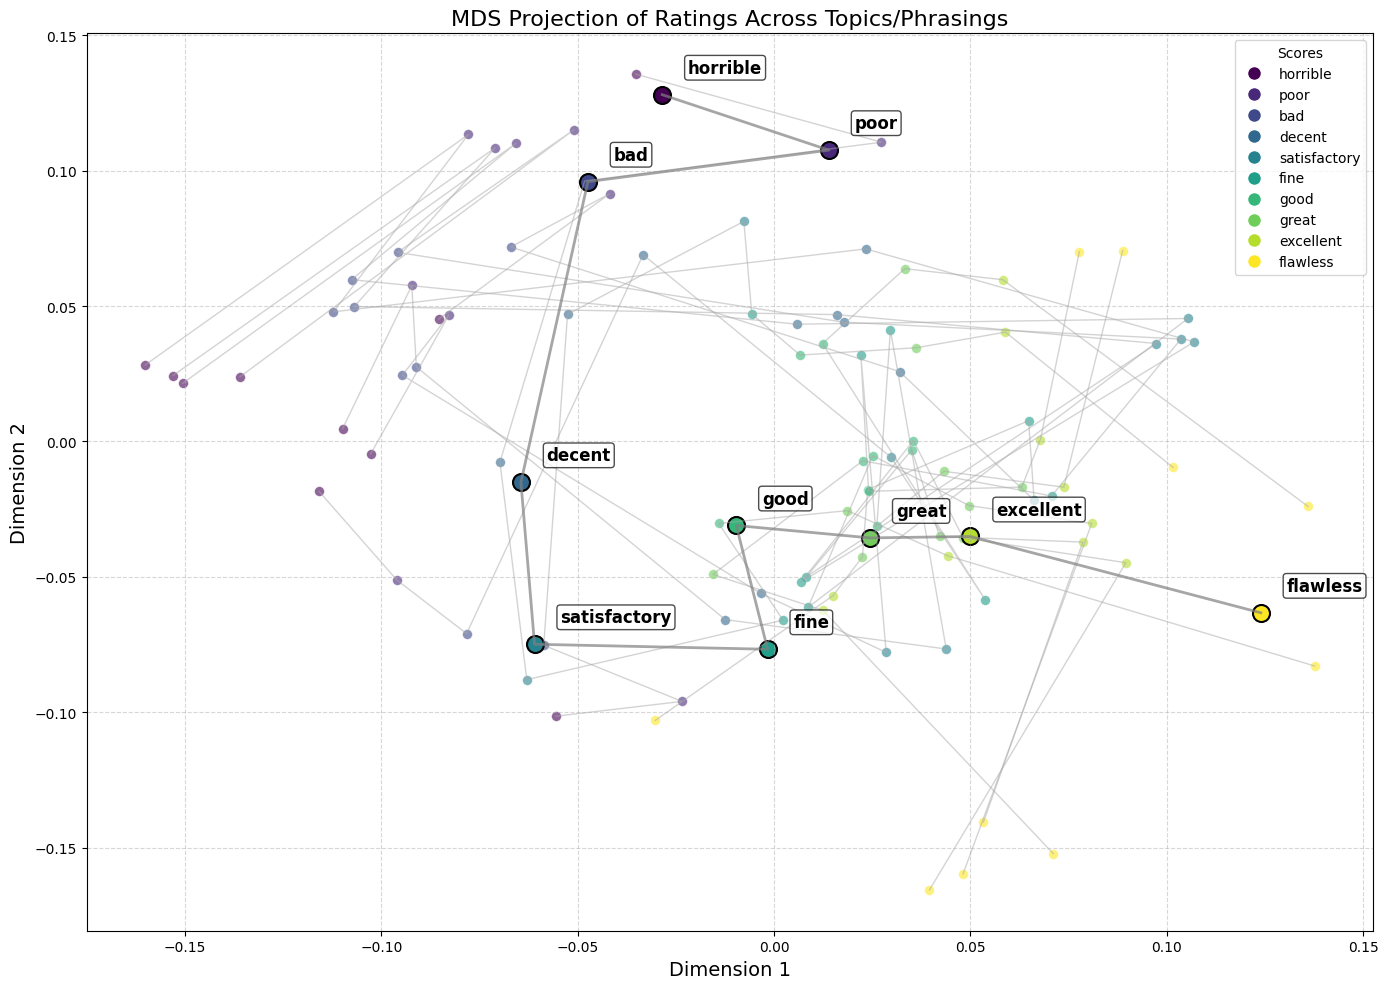

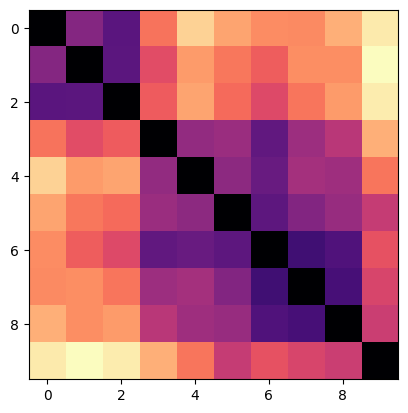

In [80]:

# Plot results selecting specific phrasings (e.g., first 3)
mds_proj.plot_results(
    all_topics_points_2d, 
    avg_points, 
    num_ratings=num_ratings, 
    selected_phrasings=[i for i in range(num_phrasings)], 
    categorical=True
)

plt.imshow(np.mean(all_dissimilarity_matrix, axis=0),cmap='magma')


In [141]:
z/10

TypeError: unsupported operand type(s) for /: 'range' and 'int'

In [88]:
embeddings_1 = get_embeddings(all_sentences[0:100], "voyage-3-large", APIKEY_VOYAGER)
embeddings_2 = get_embeddings(all_sentences[100:200], "voyage-3-large", APIKEY_VOYAGER)
embeddings_3 = get_embeddings(all_sentences[200:270], "voyage-3-large", APIKEY_VOYAGER)

embeddings = np.concatenate([embeddings_1,embeddings_2,embeddings_3])

In [75]:
embeddings.shape

(120, 1024)

In [69]:
texts = all_sentences[0]['text']
vo = voyageai.Client(api_key=APIKEY_VOYAGER)
result = vo.embed(texts, model="voyage-3", input_type="document")
emb = np.array(result.embeddings)

In [71]:
emb.shape

(1, 1024)

In [19]:
import pickle

def save_embeddings(embeddings, filepath='embeddings.pkl'):
    with open(filepath, 'wb') as f:
        pickle.dump(embeddings, f)

def load_embeddings(filepath='embeddings.pkl'):
    with open(filepath, 'rb') as f:
        return pickle.load(f)
# Usage:
# save_embeddings(embeddings,'filepath_voyage_3_large.pkl')

embeddings = load_embeddings('filepath_openai_large.pkl')

Applying MDS to each topic's embeddings...
MDS applied to all topics.
Plotting individual topics and the average projection...


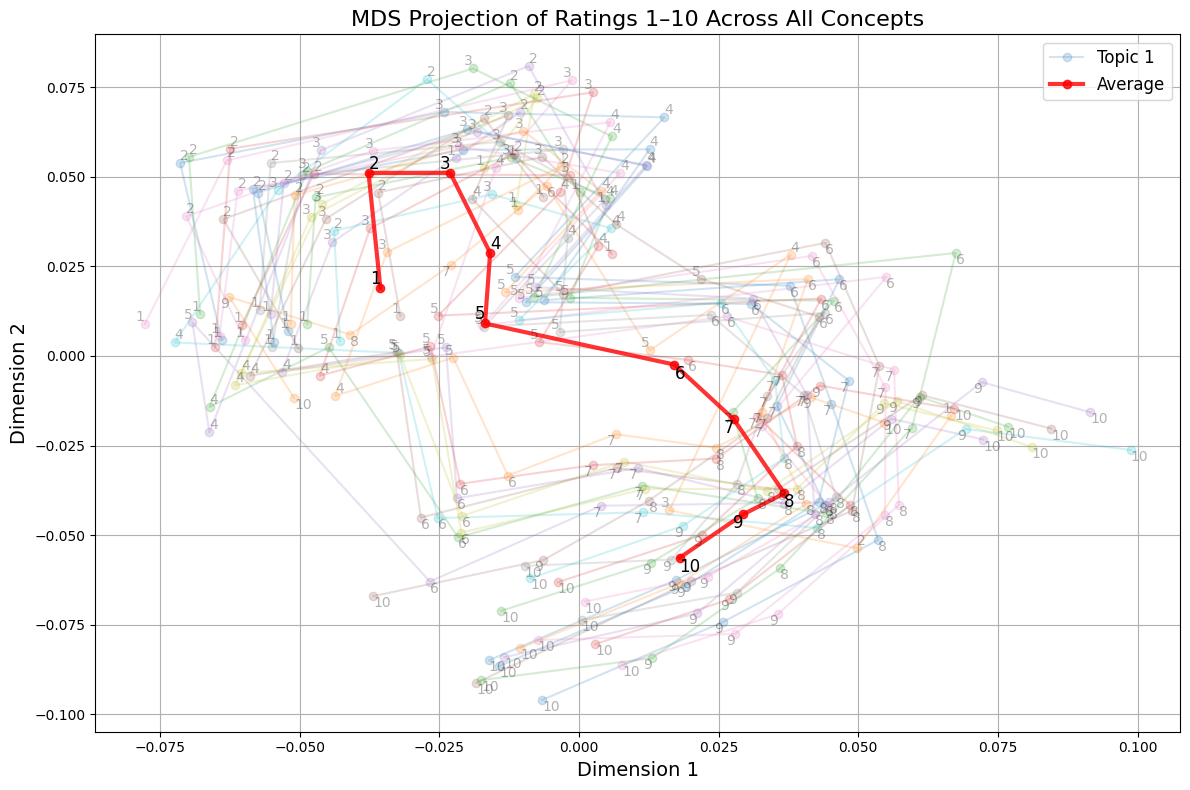

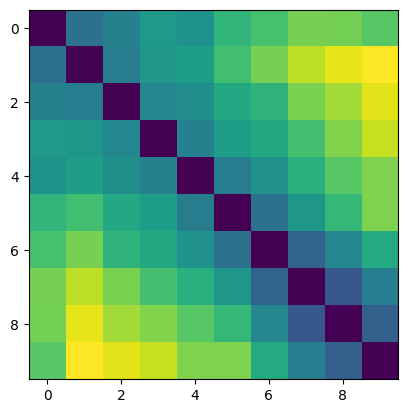

In [20]:
##############################################################################
# 3. Main Logic (Edited Snippet)
##############################################################################

# # 3.1 Generate sentences for all concepts
# all_sentences = generate_sentences(CONCEPTS)

# # 3.2 Obtain embeddings for all sentences
# print("Obtaining embeddings for all sentences...")
# embeddings = get_embeddings(all_sentences)  # shape: (100, embedding_dim)
# print("Embeddings obtained.")

# 3.3 Reshape embeddings to (10 topics, 10 ratings, embedding_dim)
num_topics = len(CONCEPTS)
num_ratings = 10
embedding_dim = embeddings.shape[1]
embeddings_reshaped = embeddings.reshape(num_topics, num_ratings, embedding_dim)

# Initialize a list to hold 2D points for each topic
all_topics_points_2d = []
all_dissimilarity_matrix = []
print("Applying MDS to each topic's embeddings...")
for topic_idx in range(num_topics):
    # Extract embeddings for the current topic
    topic_embeddings = embeddings_reshaped[topic_idx]  # shape: (10, embedding_dim)
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(topic_embeddings)  # shape: (10, 10)
    
    # Convert similarity to dissimilarity
    dissimilarity_matrix = 1.0 - similarity_matrix  # shape: (10, 10)
    all_dissimilarity_matrix.append(dissimilarity_matrix)

    # Ensure the diagonal is zero
    np.fill_diagonal(dissimilarity_matrix, 0.0)

    
    # Apply MDS to the dissimilarity matrix
    mds = MDS(
        n_components=2,
        metric=True,
        n_init=10,
        max_iter=1500,
        random_state=42,
        dissimilarity='precomputed'
    )
    points_2d = mds.fit_transform(dissimilarity_matrix)  # shape: (10, 2)
    
    # Append the 2D points for this topic
    all_topics_points_2d.append(points_2d)

print("MDS applied to all topics.")

# 3.4 Compute the average 2D points across all topics for each rating
# Initialize an array to hold averaged points
avg_points_2d = np.mean(all_topics_points_2d, axis=0)  # shape: (10, 2)

# 3.5 Plotting
print("Plotting individual topics and the average projection...")

plt.figure(figsize=(12, 8))

# Plot each topic's 2D points with low alpha
for topic_idx, topic_points in enumerate(all_topics_points_2d):
    x = topic_points[:, 0]
    y = topic_points[:, 1]
    plt.plot(x, y, marker='o', alpha=0.2, label=f'Topic {topic_idx+1}' if topic_idx < 1 else "")
    for i in range(num_ratings):
        plt.text(topic_points[i, 0], topic_points[i, 1], str(i+1), fontsize=10, alpha=0.3,
                 ha='right' if i % 2 == 0 else 'left',
                 va='bottom' if i < 5 else 'top')
    # Only label the first topic to avoid cluttering the legend

# Plot the averaged 2D points with higher alpha and thicker line
plt.plot(avg_points_2d[:, 0], avg_points_2d[:, 1], marker='o', color='red', alpha=0.8, linewidth=3, label='Average')

# Annotate the average points with their scores
for i in range(num_ratings):
    plt.text(avg_points_2d[i, 0], avg_points_2d[i, 1], str(i+1), fontsize=12,
             ha='right' if i % 2 == 0 else 'left',
             va='bottom' if i < 5 else 'top')

plt.title("MDS Projection of Ratings 1–10 Across All Concepts", fontsize=16)
plt.xlabel("Dimension 1", fontsize=14)
plt.ylabel("Dimension 2", fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.imshow(np.mean(all_dissimilarity_matrix, axis=0))

In [390]:
# embeddings_25_small = embeddings

# EVALUATE MATRICES

In [29]:
if os.exists(df_metrics):
    print('yes')

AttributeError: module 'os' has no attribute 'exists'

In [91]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# Assume all_dissimilarity_matrix is a numpy array of shape (n_samples, 10, 10)
# For example:
# all_dissimilarity_matrix = np.random.rand(5, 10, 10)

# 1. Average the dissimilarity matrices
average_dissimilarity = np.mean(all_dissimilarity_matrix, axis=0)

# 2. Flatten the upper triangle (excluding diagonal)
actual_flat = average_dissimilarity[np.triu_indices(10, k=1)]

# 3. Create a hypothetical linear dissimilarity matrix
linear_dissimilarity = np.abs(np.subtract.outer(np.arange(1, 11), np.arange(1, 11)))
linear_flat = linear_dissimilarity[np.triu_indices(10, k=1)]

# 4. Compute the Pearson correlation as the overlap metric
overlap, _ = pearsonr(actual_flat, linear_flat)

# 5. Initialize the DataFrame (if not already initialized)
new = False
if 'df_metrics' not in locals() or new: 
    print('creating new df')
    df_metrics = pd.DataFrame(columns=['model', 'overlap'])

# 6. Append the new metric using pd.concat
df_metrics = pd.concat([df_metrics, pd.DataFrame([{'model': 'voyage-3-large', 'overlap': overlap}])], ignore_index=True)

# 7. Display the DataFrame
print(df_metrics)


                   model   overlap parameters embedding_size
0       all-MiniLM-L6-v2  0.235598   22700000            384
1           openai_small  0.800798       None           1536
2           openai_large  0.889195       None           3072
3  multilingual-e5-large  0.304425        NaN           1028
4               voyage-3  0.832845        NaN           1028
5         voyage-3-large  0.728816        NaN            NaN


In [92]:
embeddings.shape

(270, 1024)

In [93]:
# df_metrics.loc[0,'parameters'] = 22700000
df_metrics.loc[5,'embedding_size'] = 1028


In [94]:
df_metrics

,model,overlap,parameters,embedding_size
0,all-MiniLM-L6-v2,0.235598,22700000,384
1,openai_small,0.800798,None,1536
2,openai_large,0.889195,None,3072
3,multilingual-e5-large,0.304425,NaN,1028
4,voyage-3,0.832845,NaN,1028
5,voyage-3-large,0.728816,NaN,1028


# google vertexai